In [2]:
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.utils.data
import numpy as np
import matplotlib.pylab as plt
import matplotlib.image as mpimg
import pandas as pd
from math import sin, cos
from PIL import ImageDraw, Image
import cv2
sys.path.append(os.path.abspath("./Residual-Attention-Network/"))
import seaborn as sns
import cv2
import time
import sklearn.preprocessing
from tqdm.notebook import tqdm
import torch.nn as nn
from sklearn.linear_model import LinearRegression
import torchvision
from torchvision.models import resnet18
module = hub.Module(name="faster_rcnn_coco2017")
%autosave 60

[2020-01-20 11:53:44,662] [    INFO] - Installing faster_rcnn_coco2017 module
[2020-01-20 11:53:44,676] [    INFO] - Module faster_rcnn_coco2017 already installed in /home/paperspace/.paddlehub/modules/faster_rcnn_coco2017


Autosaving every 60 seconds


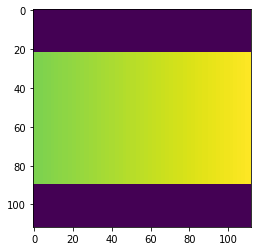

In [32]:
def rotate(x, angle):
    x = x + angle
    x = x - (x + np.pi) // (2 * np.pi) * 2 * np.pi
    return x
def pad_img(img, size = (112, 112, 3)):
    padded_img = np.zeros(size)
    pad_center_y = size[0]/2
    pad_center_x = size[1]/2
    if img.shape[0]>img.shape[1]:
        newwidth = int(img.shape[1]/img.shape[0]*size[0]//2*2)
        img = cv2.resize(img, (newwidth, size[0]))
        padded_img[:, int(pad_center_x-newwidth//2):int(pad_center_x+newwidth//2)] = img
    else:
        newheight = int(img.shape[0]/img.shape[1]*size[1]//2*2)
        img = cv2.resize(img, (size[1], newheight))
        padded_img[int(pad_center_y-newheight//2):int(pad_center_y+newheight//2), :] = img
    return padded_img
def get_numpy_mesh(shape_y, shape_x, box):
    mesh = np.zeros([shape_y, shape_x, 2])
    
    xmax, ymax, xmin, ymin = box
    mg_y, mg_x = np.meshgrid(np.linspace(ymin, ymax, shape_y), np.linspace(xmin, xmax, shape_x), indexing = 'ij')
    mesh[:, :, 0] = mg_y
    mesh[:, :, 1] = mg_x
    return mesh
class stage2Dataset(torch.utils.data.Dataset):
    def __init__(self, mode = 'train'):
        super(stage2Dataset, self)
        self.df = pd.read_csv('./Joseph_Dataset/cropped_rcnn_annotations.csv')
#         self.means = {}
#         self.stds = {}
#         keys = ['x', 'y', 'z']
#         for key in keys:
#             self.means[key] = np.mean(df[key])
#             self.stds[key] = np.std(df[key])
        if mode == 'train':
            self.df = self.df[:int(len(self.df)*0.7)]  
        else:
            self.df = self.df[int(len(self.df)*0.7):]   

    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        dic = dict(self.df.iloc[idx])
        keys = ['pred_filename','xmin', 'xmax', 'xcenter', 'ymin', 'ymax', 'ycenter', 'yaw', 'pitch', 'roll', 'x', 'y', 'z']
        pred_filename, xmin, xmax, xcenter, ymin, ymax, ycenter, yaw, pitch, roll, x, y, z = [dic[key] for key in keys]
        img = plt.imread(pred_filename).astype('float32')/255
        height, width, channels = img.shape
        mesh = get_numpy_mesh(height, width,[xmax/3384, ymax/2710, xmin/3384, ymin/2710])
        img = np.concatenate([img, mesh], axis = 2)
        img = pad_img(img, size = (112, 112, 5))
        img = img.transpose((2, 0, 1))
        xcenter = (xcenter-xmin)/(xmax-xmin)
        ycenter = (ycenter-ymin)/(ymax-ymin)
        xcenter = xcenter*2-1
        ycenter = ycenter*2-1
#         keys = ['x', 'y', 'z']
#         means = np.array([self.means[key] for key in keys])
#         stds = np.array([self.stds[key] for key in keys])
        return img,  (np.array([np.cos(yaw)>0, np.sin(yaw)*np.round(np.cos(yaw)), pitch, rotate(roll, np.pi), xcenter, ycenter])).astype('float32')

stage2set = stage2Dataset()
trainloader = torch.utils.data.DataLoader(stage2set, batch_size=128, shuffle = True)
plt.imshow(stage2set[0][0].transpose((1, 2, 0))[:, :, 4])

In [7]:
import torch
import torch.nn as nn
from torch.nn import init
import functools
from torch.autograd import Variable
import numpy as np
from model.basic_layers import ResidualBlock
from model.attention_module import AttentionModule_stage1, AttentionModule_stage2, AttentionModule_stage3, AttentionModule_stage0
from model.attention_module import AttentionModule_stage1_cifar, AttentionModule_stage2_cifar, AttentionModule_stage3_cifar
class ResidualAttentionModel_56(nn.Module):
    # for input size 224
    def __init__(self):
        super(ResidualAttentionModel_56, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.residual_block1 = ResidualBlock(64, 256)
        self.attention_module1 = AttentionModule_stage1(256, 256)
        self.residual_block2 = ResidualBlock(256, 512, 2)
        self.attention_module2 = AttentionModule_stage2(512, 512)
        self.residual_block3 = ResidualBlock(512, 1024, 2)
        self.attention_module3 = AttentionModule_stage3(1024, 1024)
        self.residual_block4 = ResidualBlock(1024, 2048, 2)
        self.residual_block5 = ResidualBlock(2048, 2048)
        self.residual_block6 = ResidualBlock(2048, 2048)
        self.mpool2 = nn.Sequential(
            nn.BatchNorm2d(2048),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=7, stride=1)
        )
        self.fc = nn.Linear(2048,7)

    def forward(self, x):
        out = self.conv1(x)
        out = self.mpool1(out)
        # print(out.data)
        out = self.residual_block1(out)
        out = self.attention_module1(out)
        out = self.residual_block2(out)
        out = self.attention_module2(out)
        out = self.residual_block3(out)
        # print(out.data)
        out = self.attention_module3(out)
        out = self.residual_block4(out)
        out = self.residual_block5(out)
        out = self.residual_block6(out)
        out = self.mpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

In [ ]:
def get_mesh(batch_size, shape_y, shape_x, box_specs):
    mesh = torch.zeros([batch_size, 2, shape_y, shape_x])
    for i in range(batch_size):
        xmax, ymax, xmin, ymin = box_specs[i].detach().numpy()
        mg_y, mg_x = np.meshgrid(np.linspace(ymin, ymax, shape_y), np.linspace(xmin, xmax, shape_x), indexing = 'ij')
        mesh[i, 0, :, :] = torch.Tensor(mg_y)
        mesh[i, 1, :, :] = torch.Tensor(mg_x)
    return mesh

def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=3):
        self.inplanes = 64 #64
        super(ResNet, self).__init__()
#        self.simplemodel = reallysimplemodel()
        self.conv1 = nn.Conv2d(5, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn0 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.selu = nn.SELU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0]) #64
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2) #128
        self.attention_module3 = AttentionModule_stage3(128, 128)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2) #256
        self.attention_module4 = AttentionModule_stage3(256, 256, (7, 7))
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2) #512
        self.avgpool = nn.AvgPool2d(4, stride=1)
        self.fc = nn.Linear(8192 * block.expansion, 200)
        self.fc1 = nn.Linear(200, 6)
        #self.bn1 = nn.BatchNorm1d(300)
#         self.fc2 = nn.Linear(300, 500)
#         self.bn2 = nn.BatchNorm1d(500)
#         self.fc3 = nn.Linear(500, 300)
#         self.bn3 = nn.BatchNorm1d(300)
#         self.fc4 = nn.Linear(300, 200)
#         self.bn4 = nn.BatchNorm1d(200)
#         self.fc5 = nn.Linear(200, 200)
#         self.bn5 = nn.BatchNorm1d(200)
        #self.fc6 = nn.Linear(300, 3)
        self.relu = nn.ReLU()
        self.selu = nn.SELU()
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        ## to compensate for the meshgrid for next round
        #self.inplanes += 2
        return nn.Sequential(*layers)
    def forward(self, x, box_specs):
        #batch_size = len(box_specs)
        #mesh = get_mesh(batch_size, x.shape[2], x.shape[3], box_specs)
        #x = torch.cat([x, mesh], dim = 1)
        
        
        x = self.conv1(x)    # 224x224
        x = self.bn0(x)     
        x = self.relu(x)
        x = self.maxpool(x)  # 112x112
        
        #mesh = get_mesh(batch_size, x.shape[2], x.shape[3], box_specs)
        #x = torch.cat([x, mesh], 1)
        
        
        
        x = self.layer1(x)   # 56x56
        #mesh = get_mesh(batch_size, x.shape[2], x.shape[3], box_specs)
        #x = torch.cat([x, mesh], 1)
        
        
        x = self.layer2(x)   # 28x28
        x = self.attention_module3(x)

        #mesh = get_mesh(batch_size, x.shape[2], x.shape[3], box_specs)
        #x = torch.cat([x, mesh], 1)
        
        
        
        x = self.layer3(x)   # 14x14
        #x = self.attention_module4(x)
        #mesh = get_mesh(batch_size, x.shape[2], x.shape[3], box_specs)
        #x = torch.cat([x, mesh], 1)
        
        x = self.layer4(x)   # 7x7
        #mesh = get_mesh(batch_size, x.shape[2], x.shape[3], box_specs)
        #x = torch.cat([x, mesh], 1)
        #x = self.avgpool(x)  # 1x1
        x = x.view(x.size(0), -1)
        X = self.relu(self.fc(x))
        X = self.fc1(X)
        return X

class reallysimplemodel(nn.Module):
    def __init__(self):
        super(reallysimplemodel, self).__init__()
        self.fc1 = nn.Linear(8, 300)
        self.fc2 = nn.Linear(300, 500)
        self.fc3 = nn.Linear(500, 300)
        self.fc4 = nn.Linear(300, 200)
        self.fc5 = nn.Linear(200, 200)
        self.fc6 = nn.Linear(200, 3)
        self.relu = nn.ReLU()
        self.selu = nn.SELU()
    def forward(self, X):
#         X1 = torch.Tensor(X)
#         X1[:, 0] = X[:, 0]/2+X[:, 2]/2
#         X1[:, 1] = X[:, 1]/2+X[:, 3]/2
#         X1[:, 2] = X[:, 0]-X[:, 2]
#         X1[:, 3] = X[:, 1] - X[:, 3]
        X1 = self.relu(self.fc1(X))
        X = self.fc2(X1)
        X = self.relu(self.fc3(X))
        X += X1
        X = self.fc4(X)
        X = self.selu(self.fc5(X))
        out = self.fc6(X)
        return out
            
# inp = k.layers.Input(shape=(4,))
# h1 = k.layers.Dense(300, activation='relu')(inp)
# h = k.layers.Dense(500, activation='selu')(h1)
# h = k.layers.Dense(300, activation='relu')(h)
# h += h1 #residue
# h = k.layers.Dense(200, activation='relu')(h)
# h = k.layers.Dense(200, activation='selu')(h)
# out = k.layers.Dense(3, activation='linear')(h)

In [ ]:
#net = ResidualAttentionModel_56() #this is the attention version, which is much slower
net = ResNet(BasicBlock, [1, 1, 1, 1]) #[2,2,2,2]
net.train()
for parameter in net.parameters():
    if len(parameter.shape)>1:
        torch.nn.init.xavier_uniform_(parameter)
net = torch.load('./Joseph_Dataset/weights/last_attention.pth')

In [ ]:
bestloss = 1

In [ ]:
np.set_printoptions(precision=2, suppress=True) 
reg_weights = [1, 1, 1, 3, 3]
reg_weights = torch.Tensor(reg_weights)
stage2set = stage2Dataset()
trainloader = torch.utils.data.DataLoader(stage2set, batch_size=32, shuffle = True) 
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.0001) 
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, 0.000001, 0.0001, step_size_up = 200, mode = 'triangular2', cycle_momentum=False, last_epoch = -1)
L1 = torch.nn.L1Loss()
BCE = torch.nn.BCEWithLogitsLoss()
idx = 0
for epoch in range(50):
    for (images, box_specs, target) in tqdm(trainloader):
        optimizer.zero_grad()
        outputs = net(images, box_specs)
        clsloss = BCE(outputs[:, 0], target[:, 0])
        regloss = L1(outputs[:, 1:], target[:, 1:])
        loss = clsloss + regloss
        print('clsloss',clsloss.detach().numpy(), 'regloss',regloss.detach().numpy(), end = '\t')
        #print accuracy for binary classification
        print('accuracy', sum((outputs[:,0].detach().numpy()>0)==target[:,0].detach().numpy()).astype(int)/32, end = '\t')
        if loss.detach().numpy()<bestloss:
            bestloss = loss.detach().numpy()
            torch.save(net, './Joseph_Dataset/weights/best_attention.pth')
            print(str(loss.detach().numpy()), 'saved!', end = '\r')
        else:
            print('totalloss', str(loss.detach().numpy())+'               ', end = '\r')
        loss.backward()
        optimizer.step()
        scheduler.step()
        if idx%30==0:
            print('\n', outputs[0].detach().numpy(), target[0].detach().numpy())
        idx+=1
    torch.save(net, './Joseph_Dataset/weights/last_attention.pth')
    print(epoch)

In [ ]:
#net = torch.load('./Joseph_Dataset/weights/net.pth')
#visualize
k = np.array([[2304.5479, 0,  1686.2379],
           [0, 2305.8757, 1354.9849],
           [0, 0, 1]], dtype = np.float32)
testfile = './train_images/ID_a381bf4d0.jpg'
image = plt.imread(testfile)
filenames, xmin, xmax, xcenter, ymin, ymax, ycenter, x, y, z = df.loc[df['original_name']==testfile][['cropped_filename','xmin','xmax', 'xcenter', 'ymin','ymax', 'ycenter', 'x', 'y', 'z']].values.T
predictors = np.zeros((len(xmin), 4))
predictors[:, 0] = xmax.astype(int)/3384
predictors[:, 1] = ymax.astype(int)/2710
predictors[:, 2] = xmin.astype(int)/3384
predictors[:, 3] = ymin.astype(int)/2710
images = np.zeros((len(filenames), 3, 112, 112))
for i, filename in enumerate(filenames):
    img = plt.imread(filename)
    img = cv2.resize(img, (112, 112))
    img = img.astype('float32').transpose((2, 0, 1))/255
    images[i] = img
images = torch.Tensor(images)
preds = net(images, torch.Tensor(predictors)).detach().numpy().astype('float32')
preds = preds*100
camera_xyz = np.dot(k, preds.T).T
camera_xyz[:, 0]/=camera_xyz[:, 2]
camera_xyz[:, 1]/=camera_xyz[:, 2]
img_xyz = camera_xyz[:, :2]
print(img_xyz.shape)
for [p_x, p_y] in img_xyz:
    cv2.circle(image, (int(p_x), int(p_y)), 5, (255, 0, 0), -1)
plt.figure(figsize = (30, 20))
plt.imshow(image)